# Carbon Management

In this example, we show how to manage different biomass stocks with different potentials and costs, synthetic fuel production, direct air capture (DAC) and carbon capture and usage/sequestration/cycling.

Demand for electricity and diesel transport have to be met from various biomass sources, natural gas with possibility for carbon capture, electrolysis for hydrogen production, direct air capture of CO2, and diesel synthesis via Fischer-Tropsch processes.

The system has to reach a target of net negative emissions over the optimisation period.

*All numbers/costs/efficiencies are fictitious to allow easy analysis.*

In [19]:
import matplotlib.pyplot as plt

import pypsa

n = pypsa.Network()
n.set_snapshots(range(10))

Add a constant electrical load, a constant demand for transport, a diesel storage, and a hydrogen storage (which are not limited in capacity).

In [20]:
n.add("Bus", "electricity")
n.add("Load", "load", bus="electricity", p_set=1)

n.add("Bus", "transport")
n.add("Load", "transport", bus="transport", p_set=1)

n.add("Bus", "diesel")
n.add("Store", "diesel", bus="diesel", e_cyclic=True, e_nom=1000)

n.add("Bus", "hydrogen")
n.add("Store", "hydrogen", bus="hydrogen", e_cyclic=True, e_nom=1000);

Add a link to represent electrolysis for hydrogen production from electricity.

In [21]:
n.add("Link", "electrolysis", p_nom=2.0, efficiency=0.8, bus0="electricity", bus1="hydrogen");

Next we set up the accounting of CO2 in the system. We add a carrier for CO2 (with minus sign because it runs opposite to how fossil fuels are used; burning of gas reduces gas, but CO2 in the atmosphere up), a bus and store for the CO2 in the atmosphere (which can be negative for the optimisation period), and a bus with a store for the CO2 that is captured and stored (for sequestration or use).

In [22]:
n.add("Carrier", "co2", co2_emissions=-1)

n.add("Bus", "co2 atmosphere", carrier="co2")
n.add("Store", "co2 atmosphere", e_nom=1000, e_min_pu=-1, bus="co2 atmosphere")

n.add("Bus", "co2 stored")
n.add("Store", "co2 stored", e_nom=1000, e_min_pu=-1, bus="co2 stored");

With that, add a multi-link for the production of diesel from H2 and CO2 using Fischer-Tropsch. Note that CO2 is another input, hence, the `efficiency2` has to be negative.

In [23]:
n.add(
    "Link",
    "Fischer-Tropsch",
    p_nom=4,
    bus0="hydrogen",
    bus1="diesel",
    bus2="co2 stored",
    efficiency=1,
    efficiency2=-1,
);

Direct air capture consumes electricity to take CO2 from the air to the store.

In [24]:
n.add(
    "Link",
    "DAC",
    bus0="electricity",
    bus1="co2 stored",
    bus2="co2 atmosphere",
    efficiency=1,
    efficiency2=-1,
    p_nom=5,
);

Add a link to meet transport demands with diesel. This emits CO2 into the atmosphere.

In [25]:
n.add(
    "Link",
    "diesel car",
    bus0="diesel",
    bus1="transport",
    bus2="co2 atmosphere",
    efficiency=1,
    efficiency2=1,
    p_nom=2,
);

Add two gas power plants, one with carbon capture and one without. The one without carbon capture emits CO2 into the atmosphere. The one with carbon capture captures CO2, but imperfectly, so that some CO2 is still emitted into the atmosphere.

In [26]:
n.add("Bus", "gas")

n.add("Store", "gas", e_initial=50, e_nom=50, marginal_cost=20, bus="gas")

n.add(
    "Link",
    "OCGT",
    bus0="gas",
    bus1="electricity",
    bus2="co2 atmosphere",
    p_nom_extendable=True,
    efficiency=0.5,
    efficiency2=1,
)

n.add(
    "Link",
    "OCGT+CCS",
    bus0="gas",
    bus1="electricity",
    bus2="co2 stored",
    bus3="co2 atmosphere",
    p_nom_extendable=True,
    efficiency=0.4,
    efficiency2=0.9,
    efficiency3=0.1,
);

Add two biomass generators, one with carbon capture and one without. The one without carbon capture simultaneously withdraws and emits CO2 into the atmosphere (hence we can ignore it for the purposes of carbon accounting). The one with carbon capture captures the renewable CO2, which counts as negative emissions if it remains in the CO2 store.

In [27]:
n.add("Bus", "biomass")

n.add(
    "Store",
    "biomass",
    bus="biomass",
    marginal_cost=30,
    e_nom=55,
    e_initial=55,
)

n.add(
    "Link",
    "biomass",
    bus0="biomass",
    bus1="electricity",
    p_nom_extendable=True,
    capital_cost=1,
    efficiency=0.5,
)

n.add(
    "Link",
    "biomass+CCS",
    bus0="biomass",
    bus1="electricity",
    bus2="co2 stored",
    bus3="co2 atmosphere",
    p_nom_extendable=True,
    capital_cost=1,
    efficiency=0.4,
    efficiency2=1,
    efficiency3=-1,
);


Finally, we add a global constraint on the amount of CO2 that can be emitted into the atmosphere.
In fact, we can set this to a negative value, which means that the system has to reach a target of net negative emissions over the optimisation period.
In this example, we can go as far as -50, but at some point not enough electricity can be generated to supply the DAC.

In [ ]:

n.add(
    "GlobalConstraint",
    "co2_limit",
    sense="<=",
    constant=-50,
);

Index(['co2_limit'], dtype='object')

In [29]:
n.optimize(log_to_console=False);

Index(['electricity', 'transport', 'diesel', 'hydrogen', 'co2 stored', 'gas',
       'biomass'],
      dtype='object', name='Bus')
Index(['electrolysis', 'Fischer-Tropsch', 'DAC', 'diesel car', 'OCGT',
       'OCGT+CCS', 'biomass', 'biomass+CCS'],
      dtype='object', name='Link')
Index(['diesel', 'hydrogen', 'co2 stored', 'gas', 'biomass'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 204 primals, 425 duals
Objective: 2.02e+03
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms


How do the different stores in the system behave?

<Axes: xlabel='snapshot'>

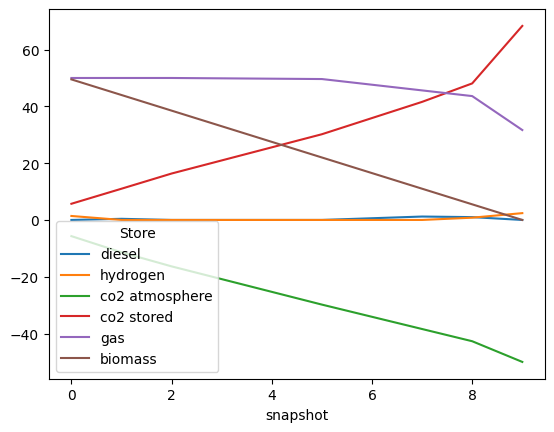

In [30]:
n.stores_t.e.plot()

Let's have a look at the production

<Axes: xlabel='snapshot'>

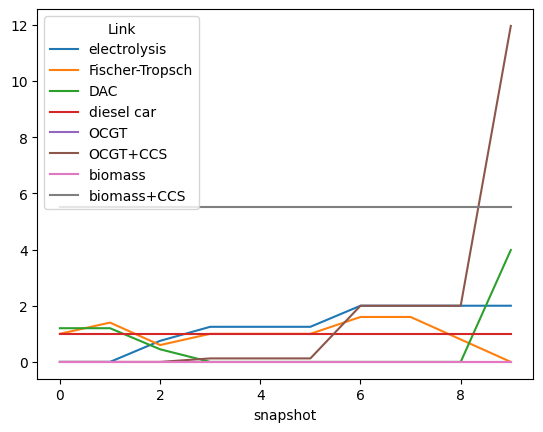

In [40]:
n.links_t.p0.plot()

At all times, the amount of carbon in the system is constant, meaning that all carbon is tracked through the system.

In [36]:
n.stores_t.e[["co2 stored", "co2 atmosphere", "gas", "diesel"]].sum(axis=1)

snapshot
0    50.0
1    50.0
2    50.0
3    50.0
4    50.0
5    50.0
6    50.0
7    50.0
8    50.0
9    50.0
dtype: float64